‚úÖ Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å: CSV Î∞è ArUco JSON
--- Í∞Å Î∑∞/Ïπ¥Î©îÎùº Ï°∞Ìï©Ïóê ÎåÄÌïú ÎåÄÌëú Ïù¥ÎØ∏ÏßÄ ÎûúÎç§ ÏÑ†ÌÉù ---
  ‚úÖ [left/leftcam] ÏÑ†ÌÉù ÏôÑÎ£å: zed_38007749_left_1748249372.014.jpg
  ‚úÖ [left/rightcam] ÏÑ†ÌÉù ÏôÑÎ£å: zed_38007749_right_1748249200.779.jpg
  ‚úÖ [right/leftcam] ÏÑ†ÌÉù ÏôÑÎ£å: zed_34850673_left_1748248983.969.jpg
  ‚úÖ [right/rightcam] ÏÑ†ÌÉù ÏôÑÎ£å: zed_34850673_right_1748249381.429.jpg
  ‚úÖ [top/leftcam] ÏÑ†ÌÉù ÏôÑÎ£å: zed_30779426_left_1748249387.336.jpg
  ‚úÖ [top/rightcam] ÏÑ†ÌÉù ÏôÑÎ£å: zed_30779426_right_1748248640.618.jpg


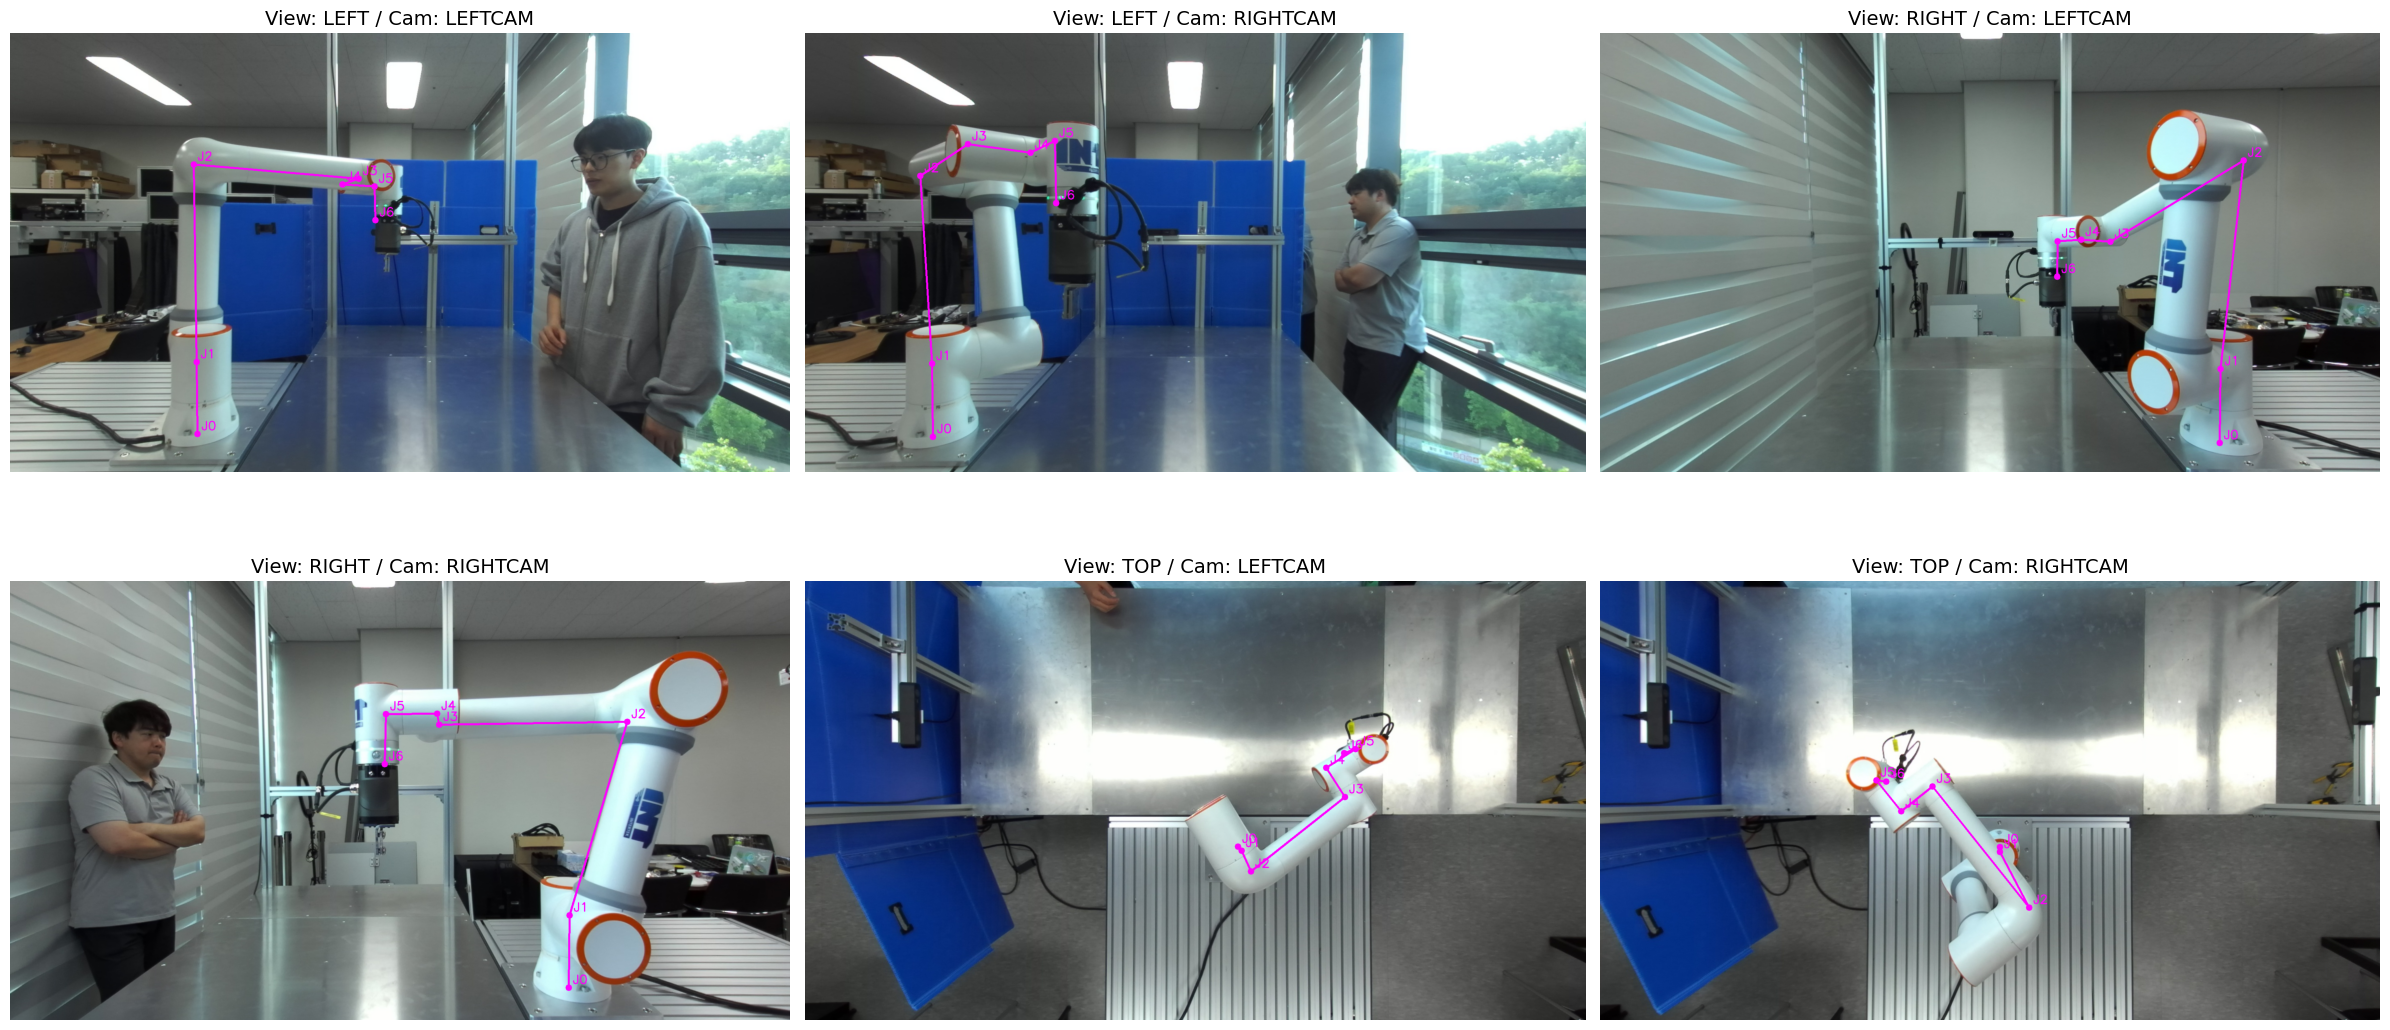

In [8]:
import os
import json
import math
import cv2
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

# --- ‚öôÔ∏è 1. ÏÑ§Ï†ï Î≥ÄÏàò ---

# ÎèôÍ∏∞ÌôîÎêú Îç∞Ïù¥ÌÑ∞ CSV ÌååÏùº Í≤ΩÎ°ú
SYNC_CSV_PATH = "../dataset/Fr5/fr5_matched_joint_angle.csv"
# ArUco ÎßàÏª§ Ìè¨Ï¶à ÏöîÏïΩ ÌååÏùº Í≤ΩÎ°ú
ARUCO_JSON_PATH = "../dataset/Fr5/Fr5_aruco_pose_summary.json"
# Ïπ¥Î©îÎùº Ï∫òÎ¶¨Î∏åÎ†àÏù¥ÏÖò ÌååÏùºÏù¥ ÏûàÎäî ÎîîÎ†âÌÜ†Î¶¨
CALIB_DIR = "../dataset/Fr5/Fr5_calib_cam_from_conf"

# Í∞Å Î∑∞ Ïù¥Î¶ÑÍ≥º Ïπ¥Î©îÎùº ÏãúÎ¶¨Ïñº Î≤àÌò∏ Îß§Ìïë
CAMERA_SERIALS = {
    "left": "38007749",
    "right": "34850673",
    "top": "30779426"
}

# --- üõ†Ô∏è 2. Ìó¨Ìçº Ìï®Ïàò ---

def get_dh_matrix(a, d, alpha, theta):
    """ÌëúÏ§Ä DH ÌååÎùºÎØ∏ÌÑ∞Î•º ÏÇ¨Ïö©ÌïòÏó¨ Î≥ÄÌôò ÌñâÎ†¨ÏùÑ Í≥ÑÏÇ∞Ìï©ÎãàÎã§. (Í∞ÅÎèÑÎäî degree Îã®ÏúÑÎ°ú ÏûÖÎ†•)"""
    alpha_rad = math.radians(alpha)
    theta_rad = math.radians(theta)
    return np.array([
        [np.cos(theta_rad), -np.sin(theta_rad) * np.cos(alpha_rad),  np.sin(theta_rad) * np.sin(alpha_rad), a * np.cos(theta_rad)],
        [np.sin(theta_rad),  np.cos(theta_rad) * np.cos(alpha_rad), -np.cos(theta_rad) * np.sin(alpha_rad), a * np.sin(theta_rad)],
        [0, np.sin(alpha_rad), np.cos(alpha_rad), d],
        [0, 0, 0, 1]
    ])

def angle_to_joint_coordinate(joint_angles, selected_view):
    """6Í∞úÏùò Í¥ÄÏ†à Í∞ÅÎèÑ(degree)Î•º ÏàúÎ∞©Ìñ• Í∏∞Íµ¨ÌïôÏùÑ ÌÜµÌï¥ 3D Ï¢åÌëúÎ°ú Î≥ÄÌôòÌï©ÎãàÎã§."""
    # FR5 Î°úÎ¥áÏùò DH ÌååÎùºÎØ∏ÌÑ∞ (Îã®ÏúÑ: ÎØ∏ÌÑ∞, ÎèÑ)
    fr5_dh_parameters = [
        {'alpha': 90,  'a': 0,      'd': 0.152, 'theta_offset': 0},
        {'alpha': 0,   'a': -0.425, 'd': 0,     'theta_offset': 0},
        {'alpha': 0,   'a': -0.395, 'd': 0,     'theta_offset': 0},
        {'alpha': 90,  'a': 0,      'd': 0.102, 'theta_offset': 0},
        {'alpha': -90, 'a': 0,      'd': 0.102, 'theta_offset': 0},
        {'alpha': 0,   'a': 0,      'd': 0.100, 'theta_offset': 0}
    ]
    
    # Ïπ¥Î©îÎùº Î∑∞Ïóê Îî∞Î•∏ Î°úÎ¥á Î≤†Ïù¥Ïä§Ïùò ÏÉÅÎåÄ ÌöåÏ†Ñ
    view_rotations = {
        'top':   R.from_euler('zyx', [-85, 0, 180], degrees=True),
        'left':  R.from_euler('zyx', [180, 0, 90],  degrees=True),
        'right': R.from_euler('zyx', [0, 0, 90],    degrees=True)
    }
    
    T_base_correction = np.eye(4)
    if selected_view in view_rotations:
        T_base_correction[:3, :3] = view_rotations[selected_view].as_matrix()

    T_cumulative = T_base_correction
    joint_coords_3d = [np.array([0, 0, 0])] # J0 (Î≤†Ïù¥Ïä§) ÏúÑÏπò
    base_point = np.array([[0], [0], [0], [1]])

    for i in range(6):
        params = fr5_dh_parameters[i]
        theta = joint_angles[i] + params['theta_offset']
        T_i = get_dh_matrix(params['a'], params['d'], params['alpha'], theta)
        T_cumulative = T_cumulative @ T_i
        joint_pos = T_cumulative @ base_point
        joint_coords_3d.append(joint_pos[:3, 0])
        
    return np.array(joint_coords_3d, dtype=np.float32)

def project_to_pixel(coords_3d, rvec, tvec, camera_matrix, dist_coeffs):
    """3D Ï¢åÌëúÎ•º 2D Ïù¥ÎØ∏ÏßÄ ÌèâÎ©¥Ïóê Ìà¨ÏòÅÌï©ÎãàÎã§."""
    # rvecÍ≥º tvecÏùÄ Î©îÏù∏ Î£®ÌîÑÏóêÏÑú ÎØ∏Î¶¨ Ï§ÄÎπÑÌïòÏó¨ Ï†ÑÎã¨Î∞õÏäµÎãàÎã§.
    pixel_coords, _ = cv2.projectPoints(coords_3d, rvec, tvec, camera_matrix, dist_coeffs)
    return pixel_coords.reshape(-1, 2)

# --- üöÄ 3. Î©îÏù∏ Ïã§Ìñâ ---

def main():
    """
    ÎèôÍ∏∞ÌôîÎêú CSV ÌååÏùºÏùÑ ÏùΩÏñ¥, Í∞Å Î∑∞/Ïπ¥Î©îÎùº Ï°∞Ìï©Ïóê ÎåÄÌïú ÎûúÎç§ Ïù¥ÎØ∏ÏßÄÎ•º ÏÑ†ÌÉùÌïòÍ≥†
    Î°úÎ¥á Í¥ÄÏ†à Îç∞Ïù¥ÌÑ∞Î•º ÏãúÍ∞ÅÌôîÌï©ÎãàÎã§.
    """
    # --- Îã®Í≥Ñ 1: Îç∞Ïù¥ÌÑ∞ Î°úÎìú ---
    try:
        df_sync = pd.read_csv(SYNC_CSV_PATH)
        with open(ARUCO_JSON_PATH, 'r') as f:
            aruco_results = json.load(f)
    except FileNotFoundError as e:
        print(f"‚ùå ÏóêÎü¨: ÌïÑÏàò ÌååÏùºÏùÑ Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§ - {e}")
        return

    print("‚úÖ Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å: CSV Î∞è ArUco JSON")

    # --- Îã®Í≥Ñ 2: ÏãúÍ∞ÅÌôîÌï† Îç∞Ïù¥ÌÑ∞ ÎûúÎç§ ÏÑ†ÌÉù ---
    views_to_plot = ['left', 'right', 'top']
    cams_to_plot = ['leftcam', 'rightcam']
    selected_rows = []

    print("--- Í∞Å Î∑∞/Ïπ¥Î©îÎùº Ï°∞Ìï©Ïóê ÎåÄÌïú ÎåÄÌëú Ïù¥ÎØ∏ÏßÄ ÎûúÎç§ ÏÑ†ÌÉù ---")
    for view in views_to_plot:
        for cam in cams_to_plot:
            # ‚ú® ÏàòÏ†ïÎêú Î∂ÄÎ∂Ñ: ÌååÏùºÎ™ÖÏóê ÎßûÎäî short name(e.g., 'left')ÏùÑ ÏÇ¨Ïö©ÌïòÏó¨ Í≤ÄÏÉâ
            cam_short_name = cam.replace("cam", "")
            
            matching_df = df_sync[
                df_sync['image_path'].str.contains(f"/{view}/") &
                df_sync['image_path'].str.contains(f"_{cam_short_name}_")
            ]
            
            if not matching_df.empty:
                selected_row = matching_df.sample(n=1).iloc[0]
                selected_rows.append(selected_row)
                img_name = os.path.basename(selected_row['image_path'])
                print(f"  ‚úÖ [{view}/{cam}] ÏÑ†ÌÉù ÏôÑÎ£å: {img_name}")
            else:
                print(f"  ‚ö†Ô∏è [{view}/{cam}] Ï°∞Ìï©Ïóê Ìï¥ÎãπÌïòÎäî Îç∞Ïù¥ÌÑ∞Î•º CSVÏóêÏÑú Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§.")

    if not selected_rows:
        print("‚ùå ÏãúÍ∞ÅÌôîÌï† Îç∞Ïù¥ÌÑ∞Î•º ÏÑ†ÌÉùÌïòÏßÄ Î™ªÌñàÏäµÎãàÎã§.")
        return
        
    # --- Îã®Í≥Ñ 3: ÏÑ†ÌÉùÎêú Îç∞Ïù¥ÌÑ∞ ÏãúÍ∞ÅÌôî ---
    fig, axes = plt.subplots(2, 3, figsize=(24, 12))
    axes = axes.flatten()

    for i, row in enumerate(selected_rows):
        ax = axes[i]
        
        # Î∑∞/Ï∫† Ï†ïÎ≥¥ Ï¥àÍ∏∞Ìôî (Ïò§Î•ò Î∞úÏÉù Ïãú Ï∂úÎ†•ÏùÑ ÏúÑÌï®)
        view, cam = "N/A", "N/A" 
        try:
            image_path = row['image_path']
            
            # CSVÏóêÏÑú Í¥ÄÏ†à Îç∞Ïù¥ÌÑ∞ Ï∂îÏ∂ú (joint_1 ~ joint_6)
            joint_angles = [row[f'joint_{j}'] for j in range(1, 7)]

            # ÌååÏùºÎ™ÖÏóêÏÑú Î∑∞ÏôÄ Ï∫† Ï†ïÎ≥¥ ÌååÏã±
            img_name = os.path.basename(image_path)
            parts = os.path.splitext(img_name)[0].split('_')
            view = [v for v in views_to_plot if f"/{v}/" in image_path][0]
            cam = parts[-2] + "cam"

            # Ìï¥Îãπ Î∑∞/Ï∫†Ïóê ÎßûÎäî ArUco Î∞è Ï∫òÎ¶¨Î∏åÎ†àÏù¥ÏÖò Îç∞Ïù¥ÌÑ∞ Ï∞æÍ∏∞
            aruco_result = next(item for item in aruco_results if item['view'] == view and item['cam'] == cam)
            
            serial = CAMERA_SERIALS[view]
            calib_path = os.path.join(CALIB_DIR, f"{view}_{serial}_{cam}_calib.json")
            with open(calib_path, 'r') as f:
                calib_data = json.load(f)

            # Ïù¥ÎØ∏ÏßÄ Î°úÎìú Î∞è ÏôúÍ≥° Î≥¥Ï†ï
            image = cv2.imread(image_path)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            camera_matrix = np.array(calib_data["camera_matrix"], dtype=np.float32)
            dist_coeffs = np.array(calib_data["distortion_coeffs"], dtype=np.float32)
            undistorted_img = cv2.undistort(image_rgb, camera_matrix, dist_coeffs)

            # ‚ú® ÏàòÏ†ïÎêú Î∂ÄÎ∂Ñ: Í∞Å Î∑∞Ïóê ÎßûÎäî Rvec, TvecÏùÑ Î™ÖÏãúÏ†ÅÏúºÎ°ú Ï∂îÏ∂úÌïòÍ≥† Î≥ÄÌôòÌï©ÎãàÎã§.
            rvec = np.array([
                math.radians(aruco_result['rvec_x']),
                math.radians(aruco_result['rvec_y']),
                math.radians(aruco_result['rvec_z'])
            ], dtype=np.float32)
            tvec = np.array([
                aruco_result['tvec_x'],
                aruco_result['tvec_y'],
                aruco_result['tvec_z']
            ], dtype=np.float32).reshape(3, 1)

            # ÏàúÎ∞©Ìñ• Í∏∞Íµ¨Ìïô Î∞è 2D Ìà¨ÏòÅ
            joint_coords_3d = angle_to_joint_coordinate(joint_angles, view)
            # ‚ú® ÏàòÏ†ïÎêú Î∂ÄÎ∂Ñ: Î™ÖÏãúÏ†ÅÏúºÎ°ú Ï∂îÏ∂úÎêú rvec, tvecÏùÑ Ìà¨ÏòÅ Ìï®ÏàòÏóê Ï†ÑÎã¨Ìï©ÎãàÎã§.
            pixel_coords = project_to_pixel(joint_coords_3d, rvec, tvec, camera_matrix, np.zeros_like(dist_coeffs))

            # Ïù¥ÎØ∏ÏßÄÏóê Î°úÎ¥á Ïä§ÏºàÎ†àÌÜ§ Í∑∏Î¶¨Í∏∞
            font = cv2.FONT_HERSHEY_SIMPLEX
            for idx, (x, y) in enumerate(pixel_coords.astype(int)):
                cv2.circle(undistorted_img, (x, y), 8, (255, 0, 255), -1) # Magenta
                cv2.putText(undistorted_img, f"J{idx}", (x + 10, y - 10), font, 1.0, (255, 0, 255), 2)
                if idx > 0:
                    prev_x, prev_y = pixel_coords[idx-1].astype(int)
                    cv2.line(undistorted_img, (prev_x, prev_y), (x, y), (255, 0, 255), 3)

            ax.imshow(undistorted_img)
            ax.set_title(f"View: {view.upper()} / Cam: {cam.upper()}", fontsize=14)

        except Exception as e:
            print(f"‚ùå [{view}/{cam}] ÏãúÍ∞ÅÌôî Ï§ë Ïò§Î•ò Î∞úÏÉù: {e}")
            ax.set_title(f"Error processing {view}/{cam}", color='red')
        finally:
            ax.axis("off")

    # ÎÇ®ÏùÄ subplot ÎπÑÌôúÏÑ±Ìôî
    for j in range(len(selected_rows), len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    main()

